# QDM Frequency adaptation analysis

Comparison of some different frequency adaptation thresholds for quantile delta mapping-based bais adjustment of precipitation.

In [ ]:
# config cell
from pathlib import Path
import numpy as np
import seaborn as sns
import xarray as xr
from scipy.stats import cramervonmises_2samp
import matplotlib.pyplot as plt
import baeda

# tmp dir for where results have been precomputed
tmp_dir = Path("/center1/CMIP6/kmredilla/downscaling/eda")
# template filename for downscaled outputs
tmp_nq_fn = "nq{n_quantiles}_{var_id}_{model}_{scenario}.zarr"
n_quantiles_list = [50, 75, 100, 150, 200, 250]

era5_idx_fp = tmp_dir.joinpath("pridx_era5.zarr")

In [ ]:
# run the pixelwise Cramer von mises test for the Rx1day indicator
# for the different frequency adaptation thresholds and combine
era5_idx = xr.open_zarr(era5_idx_fp)
era5_idx.load()

var_id = "pr"
models = ["GFDL-ESM4", "NorESM2-MM", "EC-Earth3-Veg"]
cvm_datasets = []
for n_quantiles in n_quantiles_list:
    for model in models:
        hist_idx = xr.open_zarr(
            tmp_dir.joinpath(
                tmp_nq_fn.format(
                    n_quantiles=n_quantiles,
                    var_id=var_id + "idx",
                    model=model,
                    scenario="historical",
                )
            )
        )
        hist_idx.load()
        hist_idx = hist_idx.assign_coords(model=model).expand_dims("model")

        cvm = cramervonmises_2samp(
            hist_idx["rx1day"].values.squeeze(),
            era5_idx["rx1day"].values.squeeze(),
            method="asymptotic",
        )

        dims = {dim: size for dim, size in hist_idx.sizes.items() if dim != "time"}
        new_ds = xr.Dataset(
            {
                "pvalue": (dims.keys(), np.expand_dims(cvm.pvalue, axis=[0, 1, 2])),
            },
            coords={dim: hist_idx.coords[dim] for dim in dims.keys()},
        )
        cvm_datasets.append(new_ds)

cvm_quantiles_ds = xr.merge(cvm_datasets)

### Domain-wide boxplots of 2-sample Cramér–von Mises $p$-values for different nquantile values

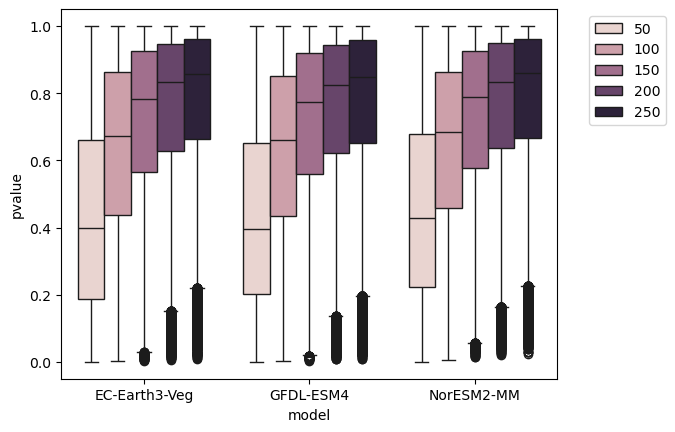

In [ ]:
df = cvm_quantiles_ds.to_dataframe().reset_index()[["model", "n_quantiles", "pvalue"]]
sns.boxplot(df.query("n_quantiles != 75"), x="model", y="pvalue", hue="n_quantiles")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

In [51]:
def plot_climo_deltas(model):
    das = []
    for n_quantiles in [50, 250]:
        hist_idx = xr.open_zarr(
            tmp_dir.joinpath(
                tmp_nq_fn.format(
                    n_quantiles=n_quantiles,
                    var_id=var_id + "idx",
                    model=model,
                    scenario="historical",
                )
            )
        )
        hist_idx.load()
        hist_idx = hist_idx

        mean_idx_deltas = hist_idx["rx1day"].mean(dim="time").isel(
            n_quantiles=0, experiment=0, drop=True
        ) - era5_idx["rx1day"].mean(dim="time")

        das.append(mean_idx_deltas)

    das[0].attrs["units"] = "mm"
    kwargs = dict(
        da1=das[0],
        da2=das[1],
        title1="50 quantiles",
        title2="250 quantiles",
        plot1_kwargs=dict(add_colorbar=False, cmap="BrBG"),
        plot2_kwargs=dict(x="x", add_colorbar=False, cmap="BrBG"),
        main_title=f"rx1day climatology deltas, {model} $-$ ERA5",
    )

    baeda.plot_sxs(**kwargs)

## Mean Rx1day deltas (GCM - ERA5) for least and most quantiles tested:

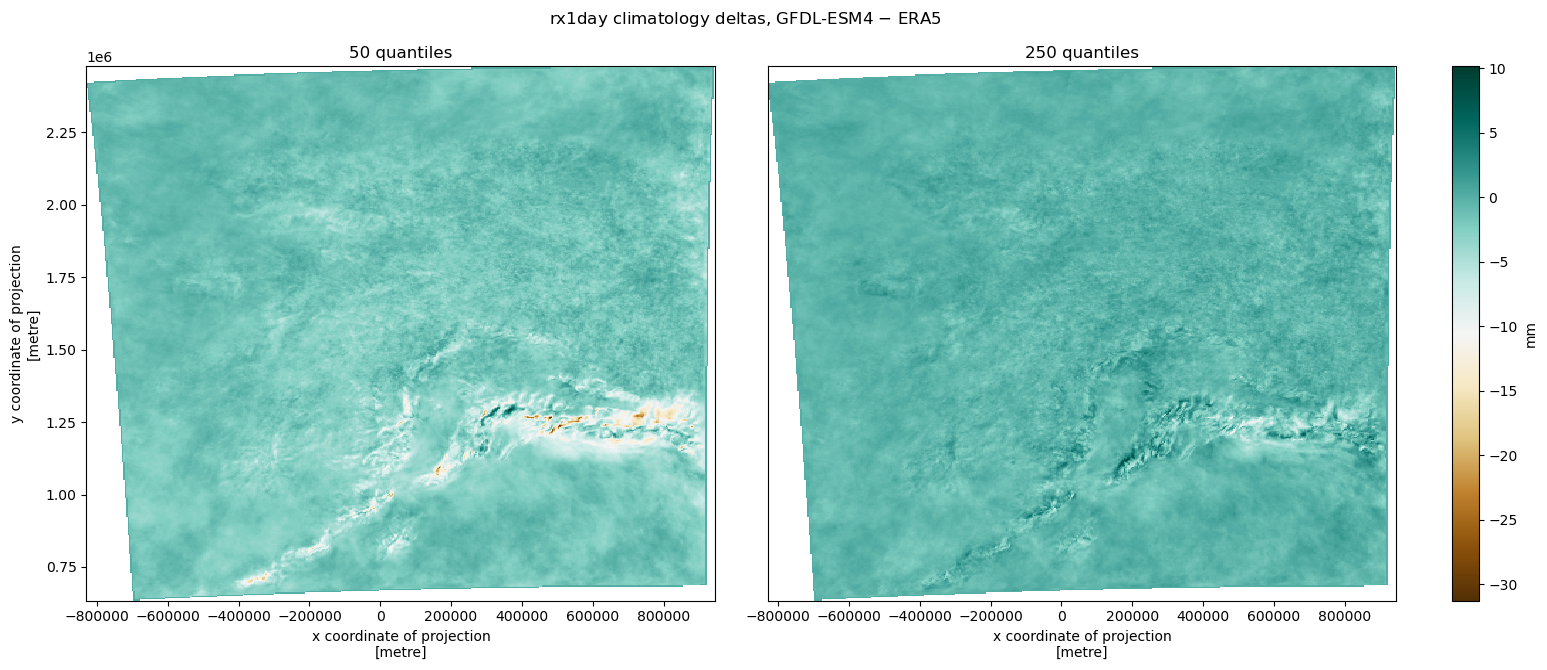

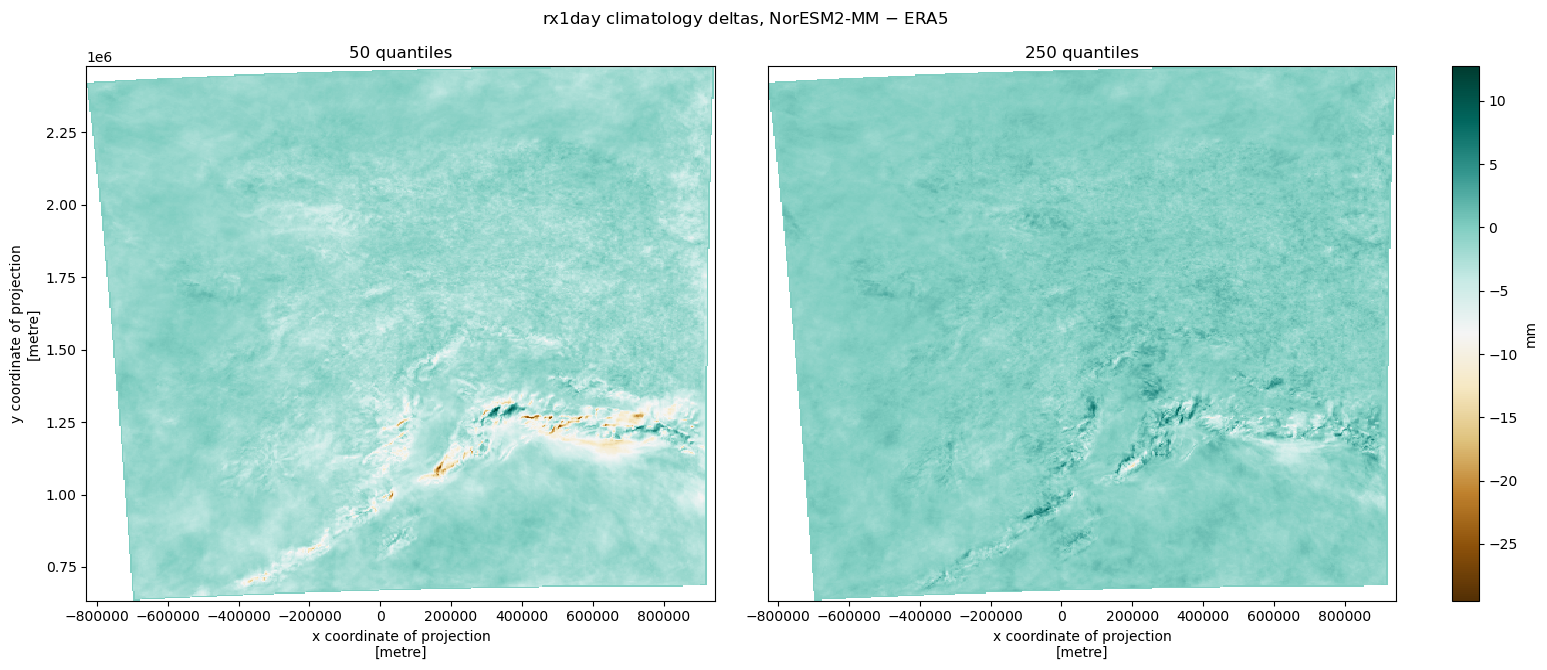

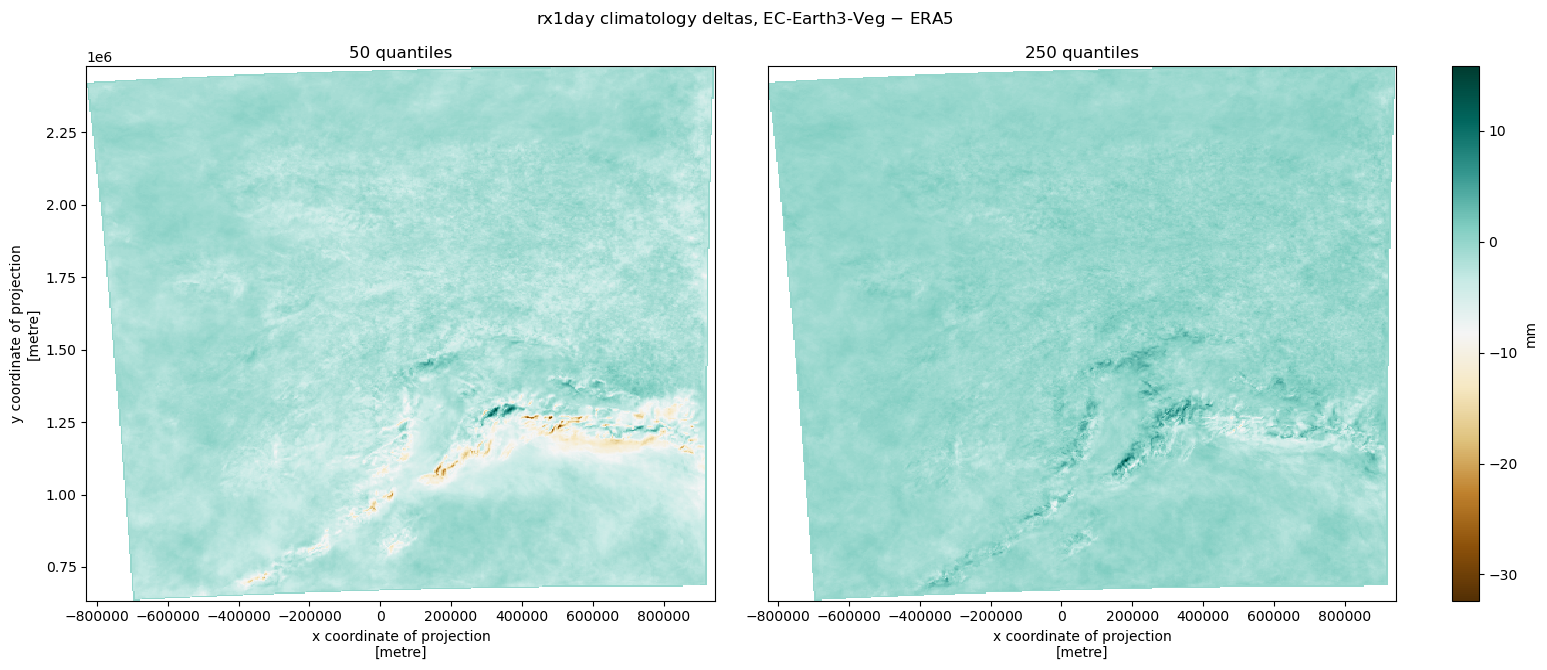

In [54]:
for model in models:
    plot_climo_deltas(model)